## Python version of example on simple HMC on p273 - p278

Simple model with two parameters ($\mu_{x}$ and $\mu_{y}$) such that the -log density is a symetrical parabolic bowl

$x_{i} \sim Normal(\mu_{x},1)$

$y_{i} \sim Normal(\mu_{y},1)$

$\mu_{x} \sim Normal(0, 0.5)$

$\mu_{y} \sim Normal(0, 0.5)$


In [16]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from jax.numpy import DeviceArray
import jax.numpy as jnp
from jax import random, lax, grad
import matplotlib.pyplot as plt

In [3]:
def U(q, a=0, b=1, k=0, d=1):
    # Potential anergy at postion q, given prior parameters a. b. k, d
    mux = q[0] # position along mux dimension
    muy = q[1] # position along muy dimension
    U1 = dist.Normal(mux, 1).log_prob(x).sum() # log prob of observing xi, given mux
    U2 = dist.Normal(muy, 1).log_prob(y).sum() # log prob of observing yi, given muy
    U3 = dist.Normal(a, b).log_prob(mux) # log prob of mux, given a,b
    U4 = dist.Normal(k, d).log_prob(muy) # log prob of muy, given k,d
    return -(U1+U2+U3+U4)

In [4]:
def U_gradient(q, a=0, b=1, k=0, d=1):
    # Analytical gradient of potential energy wrt position q
    mux = q[0] # position along mux dimension
    muy = q[1] # position along muy dimension
    G1 = jnp.sum(x - mux) + (a - mux)/b**2 # partial derivitive of U wrt mux
    G2 = jnp.sum(y - muy) + (k - muy)/d**2 # partial derivitive of U wrt muy
    return jnp.array([-G1, -G2])

In [5]:
def HMC2(U, grad_U, epsilon, L, current_q, key):
    keys = random.split(key,2)
    q = current_q
    p = dist.Normal(0,1).sample(keys[0], q.shape)
    #print(p)
    current_p = p
    # make a half-step for momentum at the beginning
    p -= epsilon * grad_U(q)/2
    # initialise bookkeeping, saves trajectory
    qtraj = jnp.empty((L+1,len(q)))
    ptraj = qtraj
    qtraj = qtraj.at[0,].set(current_q)
    ptraj = ptraj.at[0,].set(p)
    # alternate full steps for position and momentum
    for i in range(L):
        q += epsilon*p # full step for position
        # Make a full step for momentum, except at the end of the trajectory
        if i < L-1:
            p -= epsilon * grad_U(q)
            ptraj = ptraj.at[i+1,].set(p)
        qtraj = qtraj.at[i+1,].set(q)
    # make a half step in momentum at the end
    p -= epsilon * grad_U(q)/2
    ptraj = ptraj.at[L,].set(p)
    # negate momentum at the end to make the proposal symetric
    p = -p
    # evaluate potential and kinetic energies at start and end of trajectory
    #print('current_q', current_q)
    #print('q', q)
    current_U = U(current_q)
    current_K = jnp.sum(current_p**2)/2
    proposed_U = U(q)
    proposed_K = jnp.sum(p**2)/2
    #print(current_U, proposed_U, current_K, proposed_K)
    # accept or reject the proposed position
    #print(dist.Uniform().sample(keys[1]))
    #print(jnp.exp(current_U-proposed_U+current_K-proposed_K))
    if dist.Uniform().sample(keys[1]) < jnp.exp(current_U-proposed_U+current_K-proposed_K):
        new_q = q
        accept = 1
    else:
        new_q = current_q
        accept = 0
    return new_q, qtraj, ptraj, accept

In [6]:
rng_key = random.PRNGKey(7)
keys = random.split(rng_key,3)
x = dist.Normal().sample(keys[0], (50,))
y = dist.Normal().sample(keys[1], (50,))

In [7]:
q0 = jnp.array([-0.1,0.2])
L = 11
step = 0.03
n_samples = 4

### Single trajectory to obtain single sample

In [8]:
new_q, qtraj, ptraj, accept = HMC2(U, U_gradient, step, L, q0, keys[2])

Text(0, 0.5, 'muy')

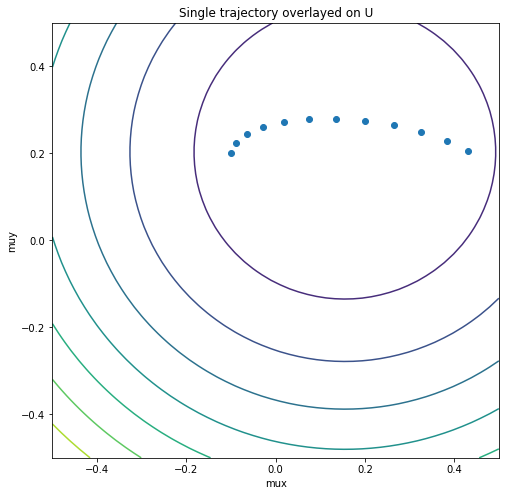

In [9]:
xi = jnp.linspace(-0.5, 0.5)
yi = jnp.linspace(-0.5, 0.5)
Uv = np.vectorize(lambda x, y: U(jnp.array([x,y])))
z = Uv(xi[:, None], yi)
plt.figure(figsize=(8,8))
plt.contour(xi, yi, z)
plt.scatter(qtraj[:,0], qtraj[:,1])
plt.title('Single trajectory overlayed on U')
plt.xlabel('mux')
plt.ylabel('muy')

### Use same code to explore Devil's funnel (p 421 - 422)

In [69]:
def U(q, s=3):
    # Potential anergy at postion q, given prior parameter s
    x = q[0] # position along x dimension
    v = q[1] # position along v dimension
    U1 = dist.Normal(0, jnp.exp(v)).log_prob(x) # log prob of observing x, given v
    U2 = dist.Normal(0, s).log_prob(v) # log prob of observing v, given that v is normally distributed with mean 0 and std. dev. s

    return -(U1 + U2)

In [24]:
# Analytical gradient
def U_gradient(q, s=3):
    # Gradient of potential energy at position q wrt to q
    x = q[0] # position along x dimension
    v = q[1] # position along v dimension
    Gv = (-v)/s**2 - 1 + jnp.exp(-2*v)*jnp.sum( x**2 ) # dU/dv
    Gx = -jnp.exp(-2*v)*x # dU/dx
    return jnp.array([-Gx, -Gv])

In [ ]:
# jax autodiff gradient
U_grad = grad(U)

In [84]:
q0 = jnp.array([-2.0,-2.0])
L = 12
step = 0.02
key = random.PRNGKey(42)

new_q, qtraj, ptraj, accept = HMC2(U, U_grad, step, L, q0, key)

Text(0, 0.5, 'v')

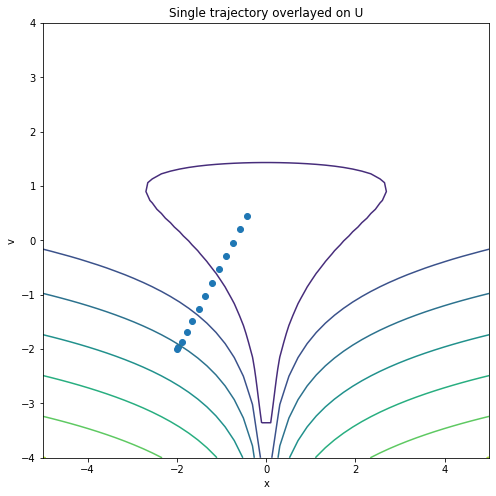

In [85]:
xi = jnp.linspace(-5, 5, 50)
yi = jnp.linspace(-4, 4, 50)
X, Y = jnp.meshgrid(xi, yi)
Uv = np.vectorize(lambda x, y: U(jnp.array([x,y])))
z = Uv(X, Y)
plt.figure(figsize=(8,8))
plt.contour(X, Y, jnp.log(z))
plt.scatter(qtraj[:,0], qtraj[:,1])
plt.title('Single trajectory overlayed on U')
plt.xlabel('x')
plt.ylabel('v')